In [197]:
import shap 
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit, train_test_split
import seaborn as sns

import src.modules as modules

In [174]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Import data
Here we use differentially expressed i.e. |ESR1|>0.5

In [3]:
df = pd.read_pickle("/data/severs/clean_cancer_old.pkl")

In [4]:
Y = df.ESR1[abs(df.ESR1)>0.5]

In [157]:
X = df.loc[abs(df.ESR1)>0.5].drop("ESR1", axis=1)

In [144]:
train_index_diff = pd.read_csv('/data/severs/trainind_patient_strat_diffexp.csv')["Resample1"].values -1

In [145]:
test_index_diff = np.zeros(691, dtype=int)
i = 0
for idk in range(X.shape[0]):
    if idk not in train_index_diff:
        test_index_diff[i] = idk
        i += 1

In [146]:
# import patient numbers for differentially expressed cells
import csv
with open('/data/severs/BP_patientnumber_diffexp.csv', newline='') as f:
    reader = csv.reader(f)
    tmp = list(reader)
    
    patient_number = list()
    for line in tmp:
        sl = line[0].split("] ")[1].split(" ")
        for s in sl:
                patient_number.append(int(s))

## Building model

The models vary very little with different parameters

In [147]:
params = {
        'eta' : 0.05, 
        'max_depth' : 6,
        'n_estimators':200,
        'subsample' : 0.8,
        'colsample_bytree' : 0.8,
        'eval_metric' :  'rmse',
        'n_jobs' : 40
}

In [148]:
model =  xgb.XGBRegressor(**params)

In [149]:
train_hist = model.fit(X.iloc[train_index_diff], Y[train_index_diff])

#### Test model

In [150]:
prediction = model.predict(X.iloc[test_index_diff])

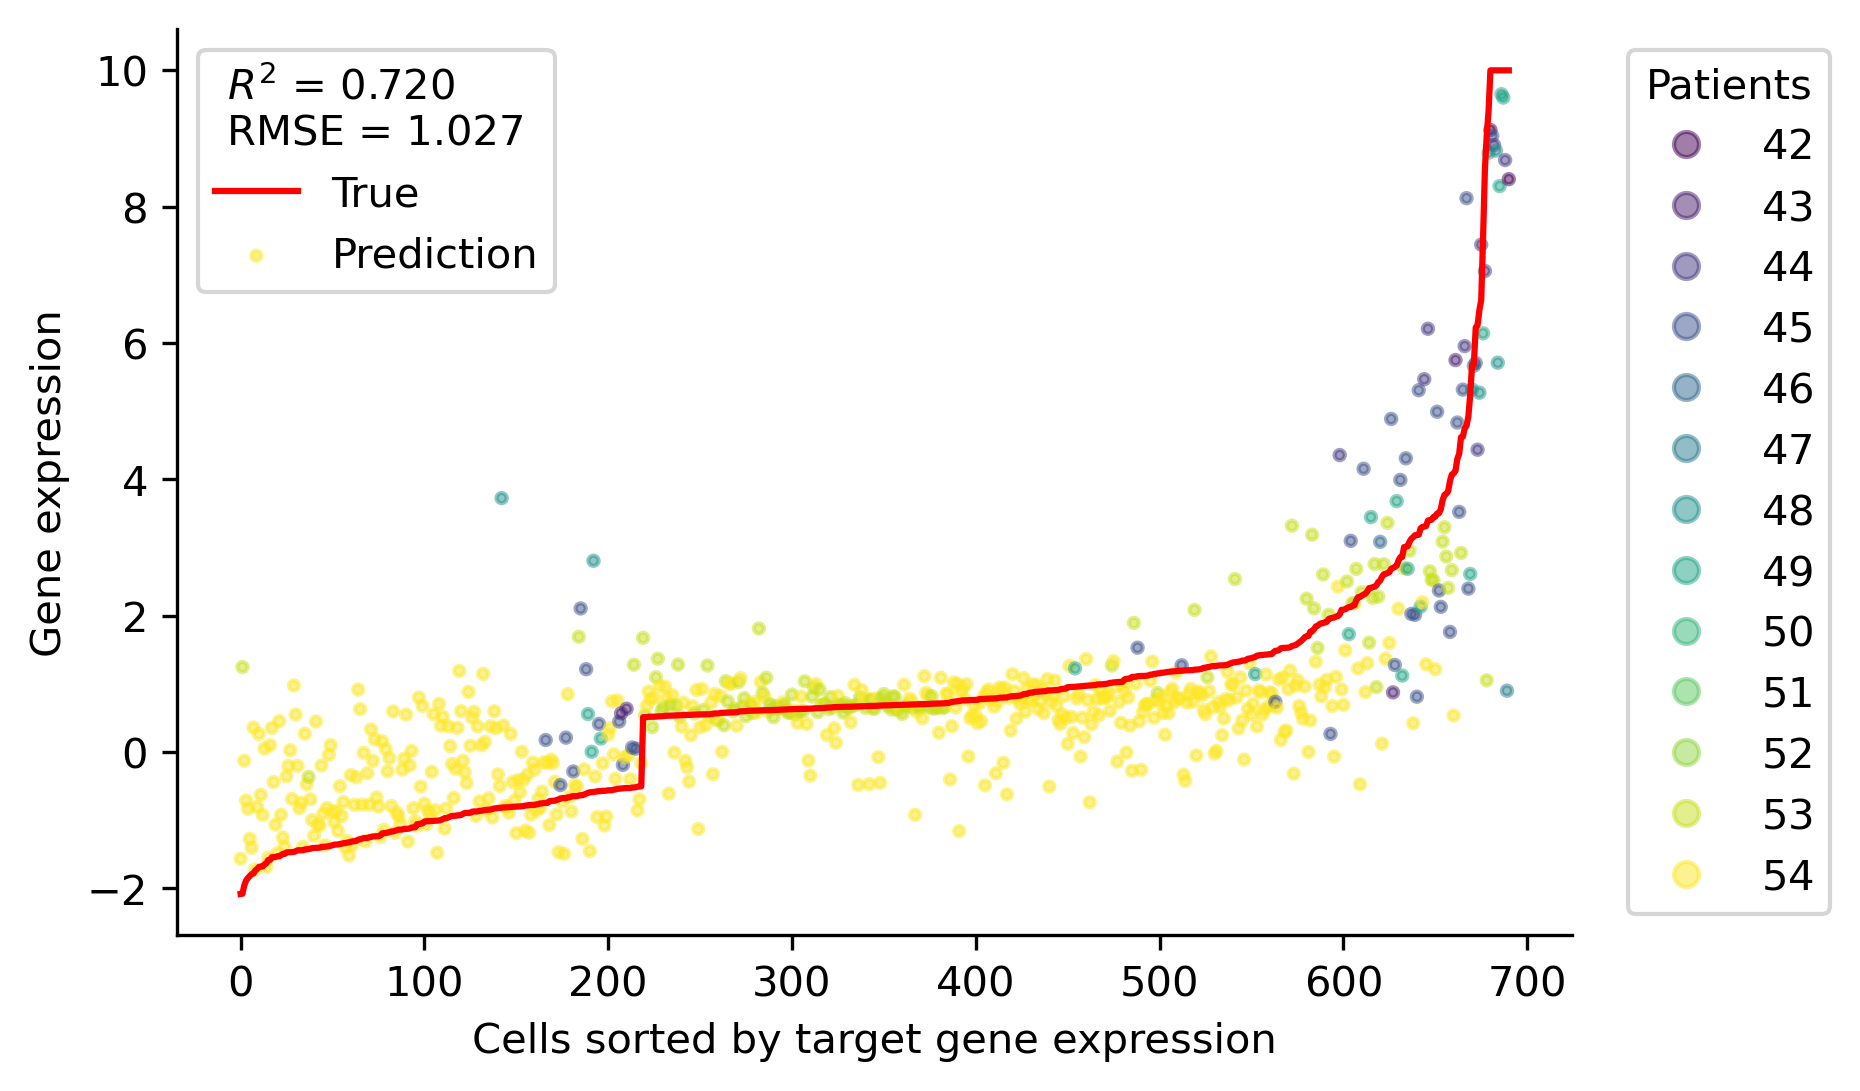

In [165]:
fig, ax = plt.subplots(dpi=300)
modules.plot_prediction(Y[test_index_diff], 
                        prediction,
                        c=np.array(patient_number)[test_index_diff],
                        fig=fig, ax=ax)
plt.show()

## Save and load model

In [159]:
model.save_model("/data/severs/xgb_model_diff.model")

In [161]:
bst = xgb.Booster({'nthread': 40})  # init model
bst.load_model('/data/severs/xgb_model_diff.model')  # load data

The loaded model requires the DMatrix format to make predictions

In [158]:
# Make data compatible for cv and loaded models
training_dmatrix = xgb.DMatrix(X.iloc[train_index_diff], label=Y[train_index_diff])
test_dmatrix = xgb.DMatrix(X.iloc[test_index_diff], label=Y[test_index_diff])

In [163]:
prediction_bst = bst.predict(test_dmatrix)

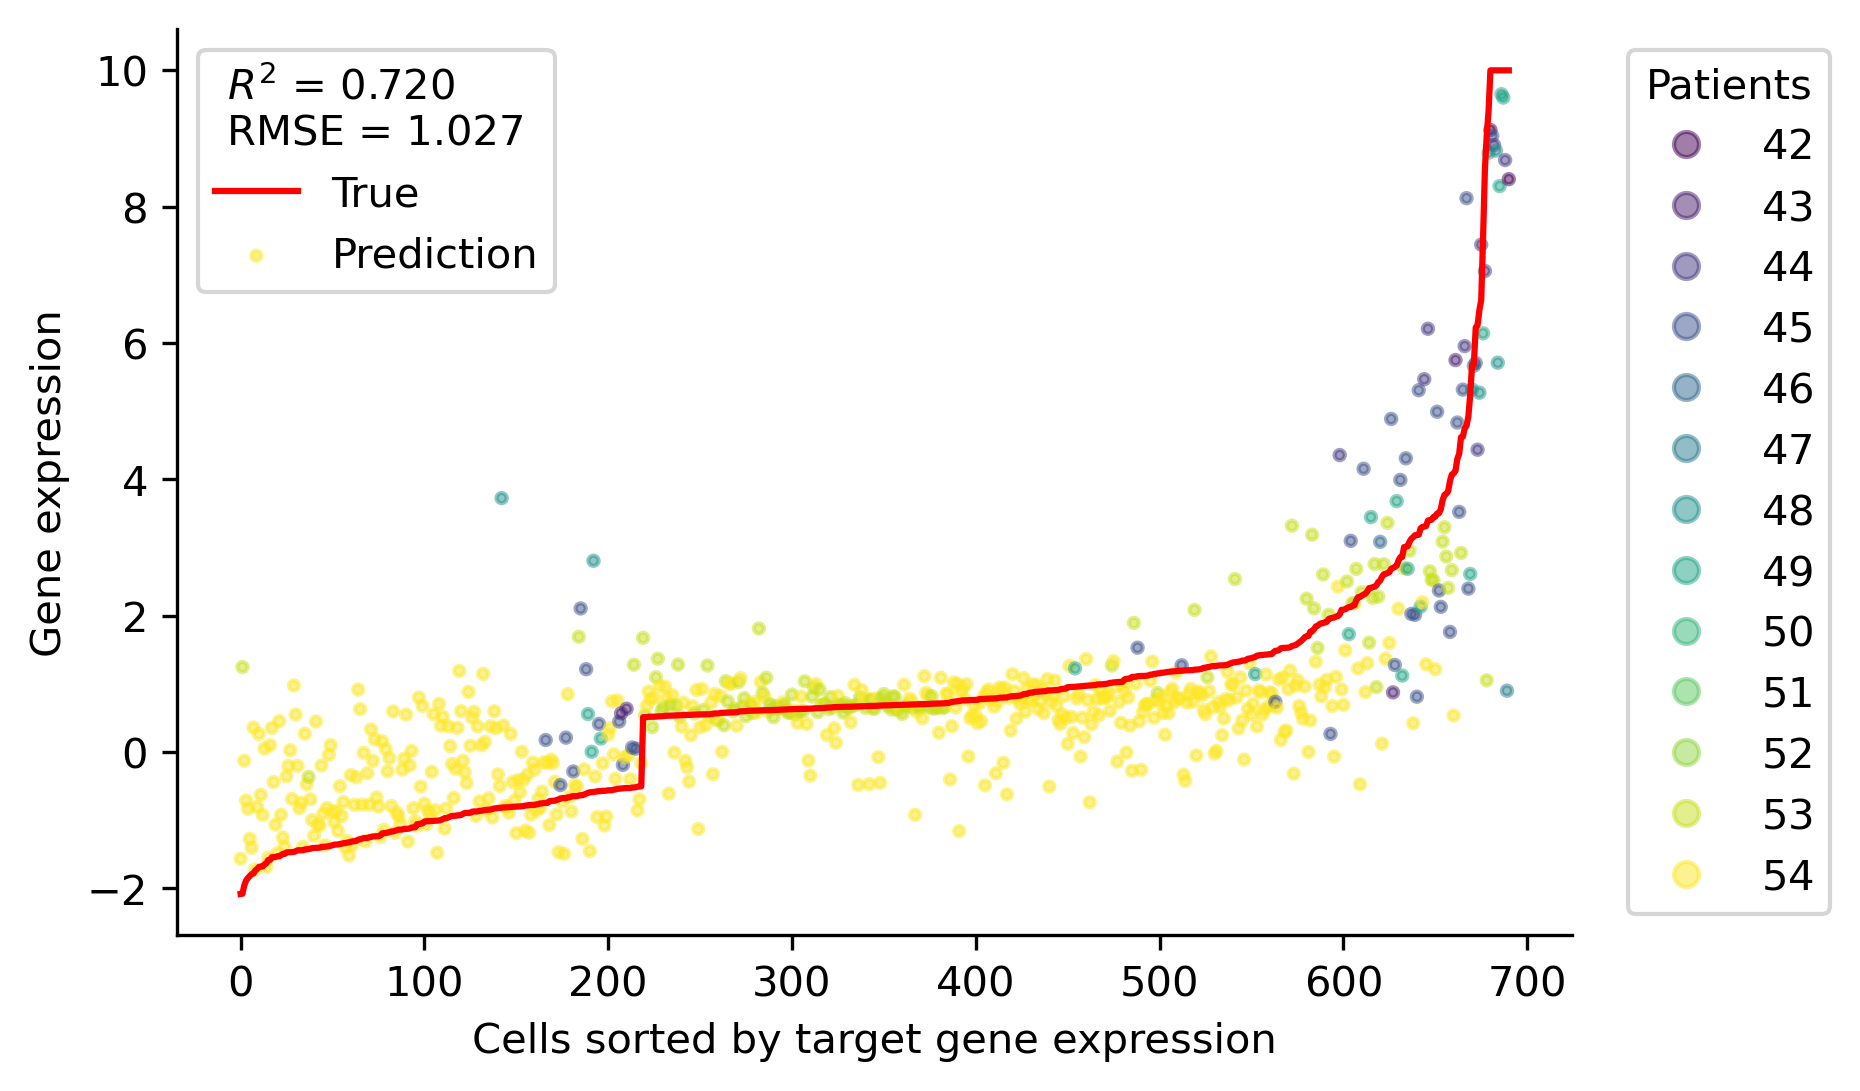

In [166]:
# Saved and loaded models makes the same predictions
fig, ax = plt.subplots(dpi=300)
modules.plot_prediction(Y[test_index_diff], 
                        prediction_bst,
                        c=np.array(patient_number)[test_index_diff],
                        fig=fig, ax=ax)
plt.show()

# Shapley analysis

It is hard to interpret the most non linear effects like EPHA1-AS1 having such a big impact because it is very close to zero for almost all cells. 

In [167]:
explainer = shap.TreeExplainer(bst)
shap_vals = explainer.shap_values(X)

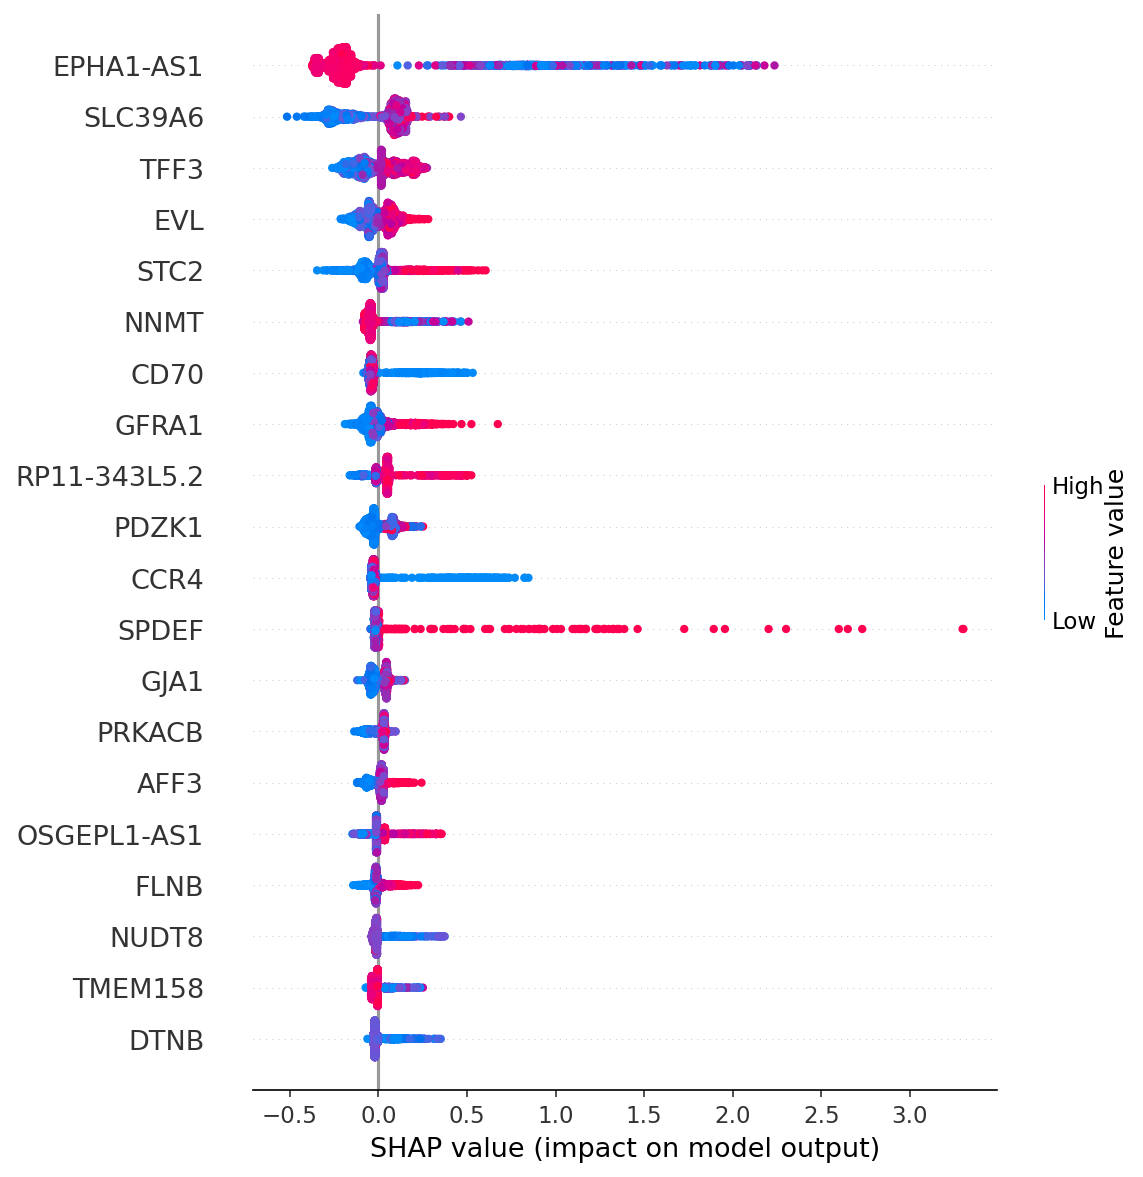

In [168]:
plt.figure(dpi=150)
shap.summary_plot(shap_vals, X,)

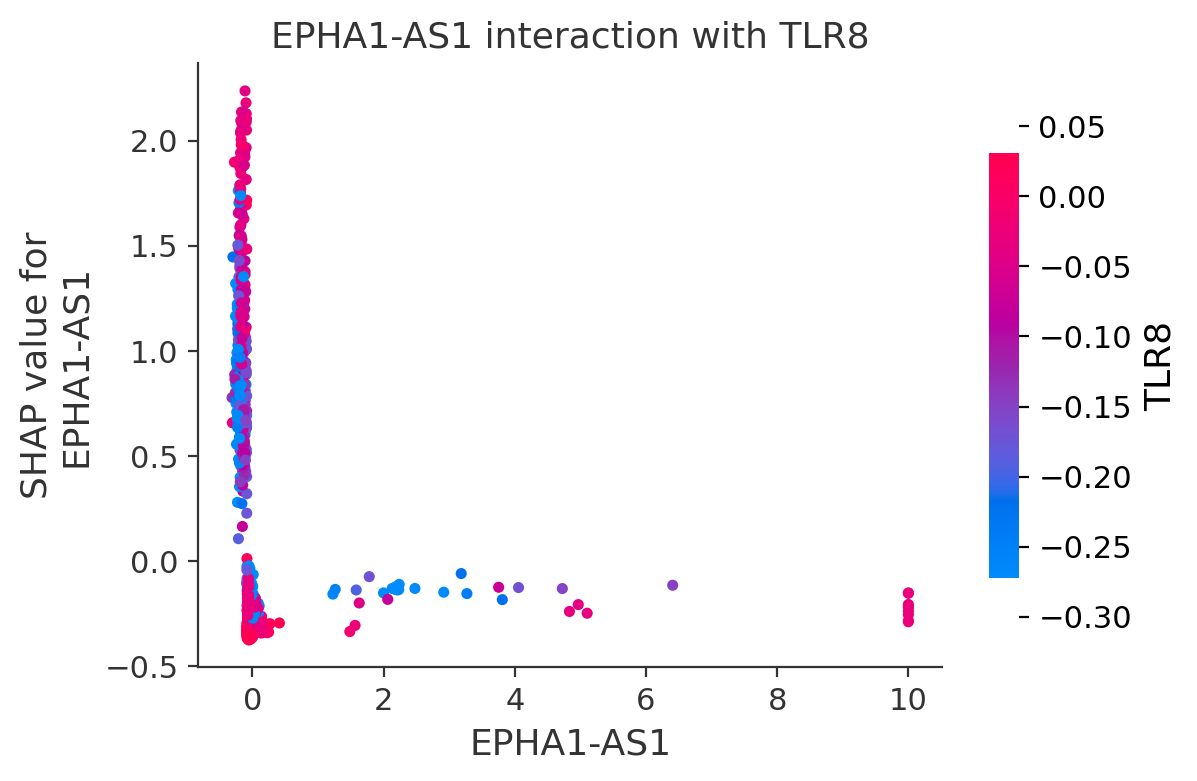

In [178]:
fig, ax = plt.subplots(dpi=200)
shap.dependence_plot(modules.get_index("EPHA1-AS1", X), 
                     shap_values=shap_vals, 
                     features=X, 
                     feature_names=X.columns, 
                     display_features=None, 
                     interaction_index=modules.get_index("TLR8", X), 
                     x_jitter=0, alpha=1, 
                     title="EPHA1-AS1 interaction with TLR8", xmin=None, xmax=None, ax=ax, show=True)


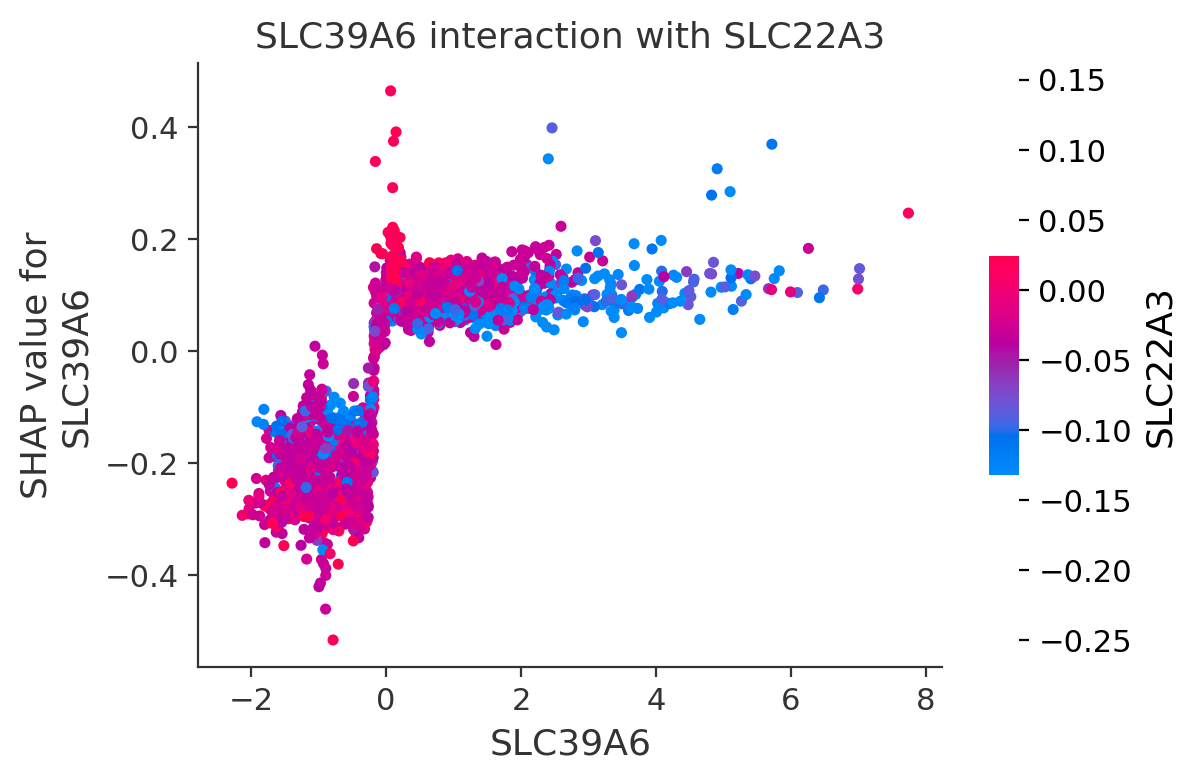

In [183]:
fig, ax = plt.subplots(dpi=200)
shap.dependence_plot(modules.get_index("SLC39A6", X), 
                     shap_values=shap_vals, 
                     features=X, 
                     feature_names=X.columns, 
                     display_features=None, 
                     interaction_index=modules.get_index("SLC22A3", X), 
                     x_jitter=0, alpha=1, 
                     title="SLC39A6 interaction with SLC22A3", xmin=None, xmax=None, ax=ax, show=True)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


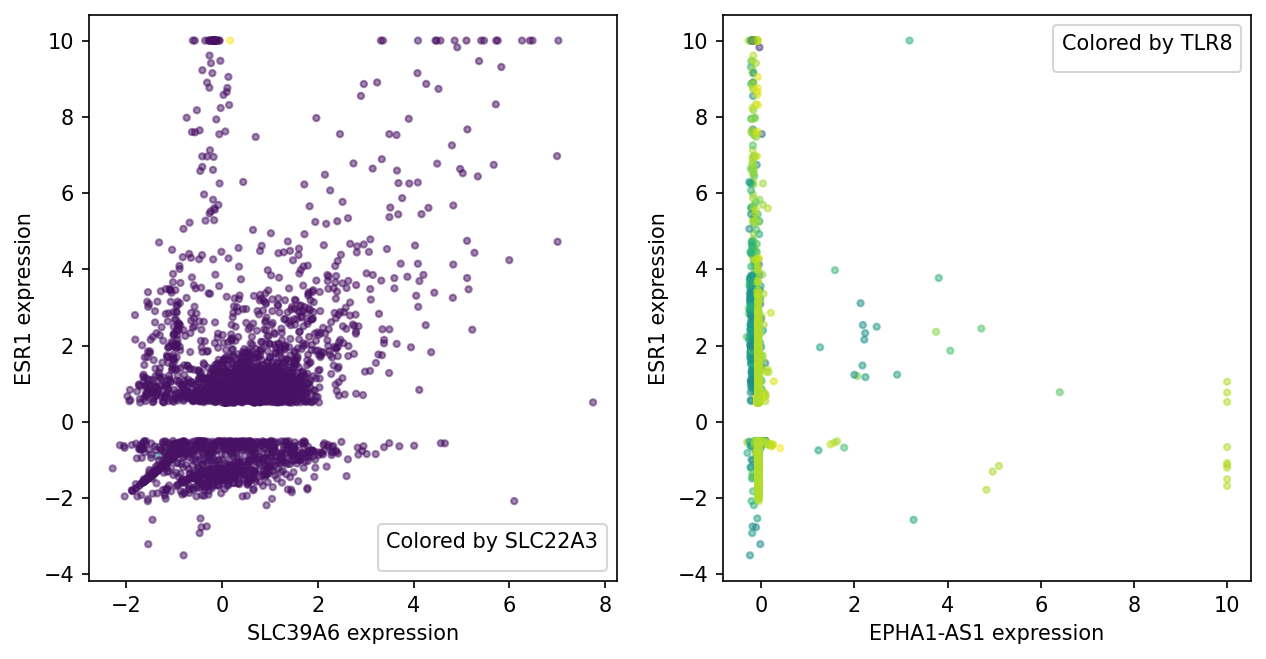

In [212]:
fig, axs = plt.subplots(1,2, dpi=150, figsize=(10,5))
axs[0].scatter(X["SLC39A6"], Y, marker=".", alpha=0.5, c=X["SLC22A3"])
axs[0].set_ylabel("ESR1 expression")
axs[0].set_xlabel("SLC39A6 expression")
axs[0].legend(title="Colored by SLC22A3")

axs[1].scatter(X["EPHA1-AS1"], Y, marker=".", alpha=0.5, c=X["TLR8"])
axs[1].set_ylabel("ESR1 expression")
axs[1].set_xlabel("EPHA1-AS1 expression")
axs[1].legend(title="Colored by TLR8")

#fig.colorbar(cm.ScalarMappable(), ax=axs[1])
plt.show()

# Cross validated result training set

In [180]:
cv_params = params.copy()
del cv_params["n_estimators"]

In [181]:
cv_result = xgb.cv(cv_params, training_dmatrix, num_boost_round=200, verbose_eval=50)

[0]	train-rmse:1.93915+0.05148	test-rmse:1.95240+0.10361
[50]	train-rmse:0.60995+0.01203	test-rmse:1.17800+0.06160
[100]	train-rmse:0.34432+0.00961	test-rmse:1.13043+0.05442
[150]	train-rmse:0.22127+0.00399	test-rmse:1.12405+0.05323
[199]	train-rmse:0.14840+0.00288	test-rmse:1.12185+0.05179


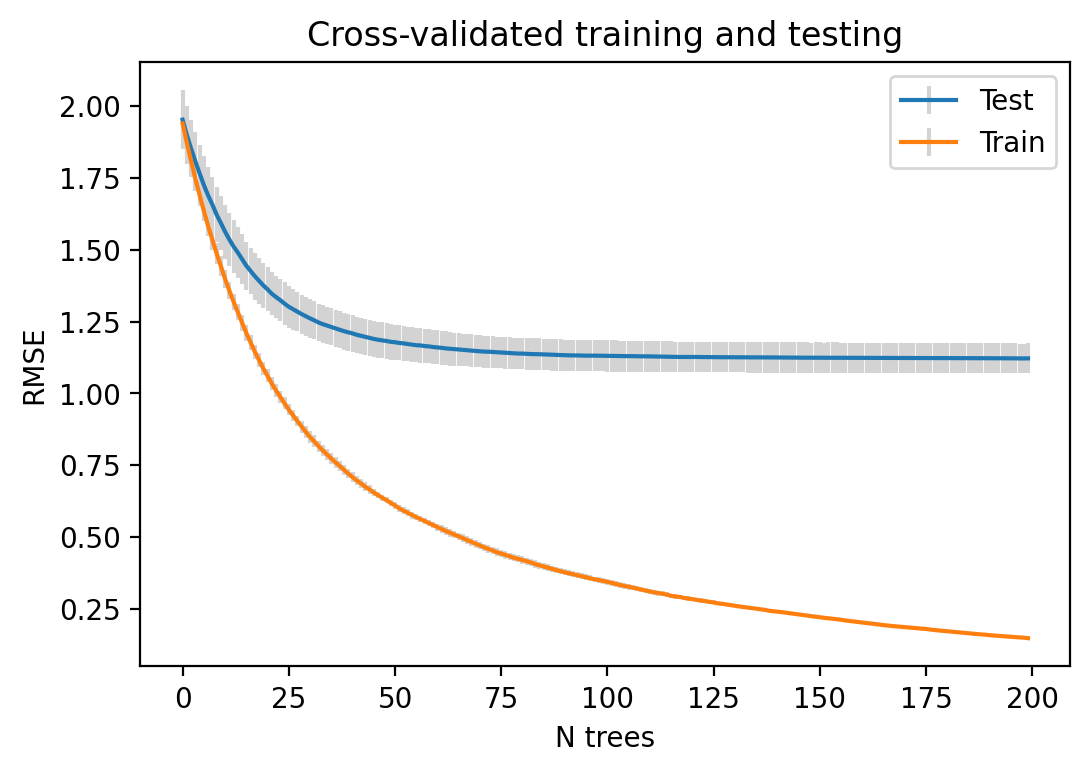

In [182]:
plt.figure(dpi=200)
plt.errorbar(np.arange(200), cv_result["test-rmse-mean"], cv_result["test-rmse-std"],
             linestyle='-', marker=None, label="Test", ecolor="lightgrey")
plt.errorbar(np.arange(200), cv_result["train-rmse-mean"], cv_result["train-rmse-std"],
             linestyle='-', marker=None, label="Train", ecolor="lightgrey")
plt.legend()
plt.xlabel("N trees")
plt.ylabel("RMSE")
plt.title("Cross-validated training and testing")
plt.show()